In [1]:
from land_cover import load
from land_cover.plotting import plot_basemap
from land_cover.plotting import _crs2ccrs, _cartopy_albers
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import geopandas as gpd
from pyproj.crs.crs import CRS
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io import img_tiles
import seaborn as sns

from land_cover.distance import calcMeanBoundDist, calcMeanBoundDistSerial

%load_ext autoreload
%autoreload 2

In [2]:
shp_out = '/Volumes/metis/ABOVE3/Tom/Selected_PLD_Lakes_2024-10-21/added_PLD/Efflux_Bogard_PLD_WBD.shp'

In [3]:
df = pd.read_excel('/Volumes/metis/ABOVE3/Tom/PrelimLakeMatchupData_2024-10-21.xlsx', sheet_name='Measurements')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8714 entries, 0 to 8713
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OID_           8714 non-null   int64  
 1   lat            6245 non-null   float64
 2   long           6245 non-null   float64
 3   Reference      6245 non-null   object 
 4   pco2uatm       6245 non-null   float64
 5   A              6245 non-null   float64
 6   B              6245 non-null   float64
 7   C              6245 non-null   float64
 8   Lat_DD         891 non-null    float64
 9   Lon_DD         891 non-null    float64
 10  AvgOfTempC     891 non-null    float64
 11  AvgOfpH        891 non-null    float64
 12  AvgOfALKum     891 non-null    float64
 13  AvgOfCO2_o     891 non-null    float64
 14  StDevOfCO2     891 non-null    float64
 15  AvgOfpCO2      891 non-null    float64
 16  StDevOfpCO     891 non-null    float64
 17  Name.1         1578 non-null   object 
 18  PopupInf

In [4]:
# TODO: import from dict in load.py
# df_no_geom = df[df['lake_id'].isna()].query("Name == 'EffluxLakes'")
df_no_geom = df[df['lake_id'].isna()].query("Name == 'EffluxLakes' or Name == 'BogardMapLakes'")

# Fill equiv vals bw datasets
df_no_geom['AvgOfpCO2'] = df_no_geom['AvgOfpCO2'].fillna(df['pco2uatm'])
df_no_geom['Lat_DD'] = df_no_geom['Lat_DD'].fillna(df['lat'])
df_no_geom['Lon_DD'] = df_no_geom['Lon_DD'].fillna(df['long'])

# query North America only
df_no_geom.query("Lon_DD < -50", inplace=True)

df_no_geom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 521 entries, 3301 to 7575
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OID_           521 non-null    int64  
 1   lat            229 non-null    float64
 2   long           229 non-null    float64
 3   Reference      229 non-null    object 
 4   pco2uatm       229 non-null    float64
 5   A              229 non-null    float64
 6   B              229 non-null    float64
 7   C              229 non-null    float64
 8   Lat_DD         521 non-null    float64
 9   Lon_DD         521 non-null    float64
 10  AvgOfTempC     292 non-null    float64
 11  AvgOfpH        292 non-null    float64
 12  AvgOfALKum     292 non-null    float64
 13  AvgOfCO2_o     292 non-null    float64
 14  StDevOfCO2     292 non-null    float64
 15  AvgOfpCO2      521 non-null    float64
 16  StDevOfpCO     292 non-null    float64
 17  Name.1         0 non-null      object 
 18  PopupInfo  

In [5]:
gdf_no_geom = gpd.GeoDataFrame(df_no_geom, geometry=gpd.points_from_xy(df_no_geom['Lon_DD'], df_no_geom['Lat_DD']), crs='EPSG:4326')


In [6]:
gdf_wbd = load.loadWBD()

In [7]:
# Reproject both GeoDataFrames to ESRI:102001
gdf_no_geom = gdf_no_geom.to_crs('ESRI:102001')
gdf_wbd = gdf_wbd.to_crs('ESRI:102001')

# Buffer gdf_no_geom by 80 meters
gdf_no_geom['geometry'] = gdf_no_geom.buffer(80)

# Perform the spatial join (default is 'inner' join based on 'intersects')
gdf_joined_wbd = gpd.sjoin(gdf_wbd, gdf_no_geom, how="inner")

# View the result
print(gdf_joined_wbd.info())


<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 80 entries, 133896 to 1114512
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       80 non-null     float64 
 1   ID             80 non-null     float64 
 2   GRIDCODE       80 non-null     float64 
 3   Area           80 non-null     float64 
 4   SI             80 non-null     float64 
 5   Shape_Leng     80 non-null     float64 
 6   Shape_Area     80 non-null     float64 
 7   PA             80 non-null     float64 
 8   PA_Circle      80 non-null     float64 
 9   Perimeter      80 non-null     float64 
 10  river          5 non-null      float64 
 11  on_glacier     0 non-null      float64 
 12  geometry       80 non-null     geometry
 13  index_right    80 non-null     int64   
 14  OID_           80 non-null     int64   
 15  lat            18 non-null     float64 
 16  long           18 non-null     float64 
 17  Reference      18 non-nu

<Axes: >

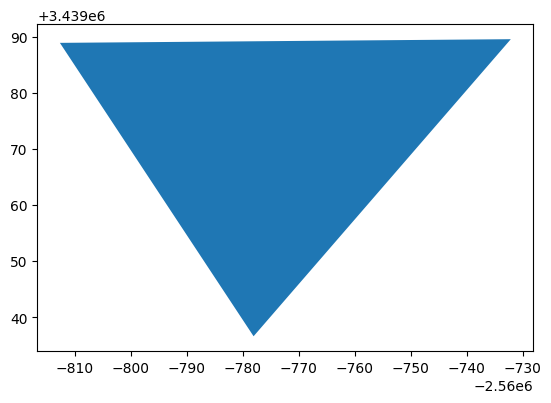

In [8]:
gdf_joined_wbd[:1].plot()


In [9]:
## Remove dups
gdf_joined_wbd = gdf_joined_wbd.groupby('OBJECTID').first().reset_index()
gdf_joined_wbd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 37 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   OBJECTID       69 non-null     float64 
 1   ID             69 non-null     float64 
 2   GRIDCODE       69 non-null     float64 
 3   Area           69 non-null     float64 
 4   SI             69 non-null     float64 
 5   Shape_Leng     69 non-null     float64 
 6   Shape_Area     69 non-null     float64 
 7   PA             69 non-null     float64 
 8   PA_Circle      69 non-null     float64 
 9   Perimeter      69 non-null     float64 
 10  river          3 non-null      float64 
 11  on_glacier     0 non-null      float64 
 12  geometry       69 non-null     geometry
 13  index_right    69 non-null     int64   
 14  OID_           69 non-null     int64   
 15  lat            17 non-null     float64 
 16  long           17 non-null     float64 
 17  Reference      17 non-null   

In [10]:
gdf_joined_wbd.head()
# gdf_joined_wbd.Name.unique()

,OBJECTID,ID,GRIDCODE,Area,SI,Shape_Leng,Shape_Area,PA,PA_Circle,Perimeter,...,AvgOfCO2_o,StDevOfCO2,AvgOfpCO2,StDevOfpCO,Name.1,PopupInfo,LabelID,Name,lake_id,LitReviewInfo
0,2002061.0,919878.0,1.0,0.002056,1.306532,0.002964,3.535318e-07,102.153976,78.187119,0.209988,...,8.979405,0.0,173.721373,0.0,None,None,NaN,EffluxLakes,NaN,0
1,2002781.0,938004.0,1.0,0.007230,1.377205,0.005352,1.241397e-06,57.416943,41.690914,0.415114,...,610.705734,0.0,8715.373549,0.0,None,None,NaN,EffluxLakes,NaN,0
2,2018213.0,37677.0,1.0,0.001782,1.468400,0.002856,2.952863e-07,123.304466,83.971970,0.219746,...,48.978071,0.0,966.702283,0.0,None,None,NaN,EffluxLakes,NaN,0
3,2019929.0,45342.0,1.0,0.000951,1.289364,0.001920,1.571984e-07,148.241287,114.972435,0.140926,...,300.773631,0.0,6155.211912,0.0,None,None,NaN,EffluxLakes,NaN,0
4,2021727.0,55610.0,1.0,0.002277,1.159875,0.002690,3.753026e-07,86.168533,74.291237,0.196193,...,79.463304,0.0,1282.321847,0.0,None,None,NaN,EffluxLakes,NaN,0


In [11]:
gdf_efflux = load.loadEffluxShp()

In [23]:
gdf_bogard = load.loadBogardMapShp()

In [24]:
gdf_bogard.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 45 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   lake_id        151 non-null    float64 
 1   Lake_area      151 non-null    float64 
 2   Outlet_n       151 non-null    int64   
 3   D_lake_id      133 non-null    object  
 4   D_lake_n       151 non-null    int64   
 5   D_lak_ntot     151 non-null    int64   
 6   U_lake_n       151 non-null    int64   
 7   U_lak_ntot     151 non-null    int64   
 8   Cat_a_lake     151 non-null    float64 
 9   Lake_type      151 non-null    object  
 10  Lake_order     151 non-null    int64   
 11  Laktyp_mhv     151 non-null    object  
 12  Lperm_glcp     151 non-null    float64 
 13  Basin_id       151 non-null    object  
 14  MERGE_SRC      151 non-null    object  
 15  Shape_Leng     151 non-null    float64 
 16  Shape_Area     151 non-null    float64 
 17  PLDNdistm_     0 non-null  

In [25]:
gdf_combined  = pd.concat([gdf_efflux.to_crs("ESRI:102001"), gdf_joined_wbd, gdf_bogard.to_crs("ESRI:102001")], ignore_index=True)

/Users/ekyzivat/mambaforge/envs/landcover/lib/python3.11/site-packages/geopandas/array.py:1638: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as Canada_Albers_Equal_Area_Conic (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


In [26]:
gdf_combined.head()
gdf_combined.columns

Index(['lake_id', 'Lake_area', 'Outlet_n', 'D_lake_id', 'D_lake_n',
       'D_lak_ntot', 'U_lake_n', 'U_lak_ntot', 'Cat_a_lake', 'Lake_type',
       'Lake_order', 'Laktyp_mhv', 'Lperm_glcp', 'Basin_id', 'MERGE_SRC',
       'Shape_Leng', 'Shape_Area', 'PLDNdistm_', 'Area_sqkm', 'Perimtr_km',
       'CentLong', 'CentLat', 'geometry', 'OID_', 'lat', 'long', 'Reference',
       'pco2uatm', 'A', 'B', 'C', 'Lat_DD', 'Lon_DD', 'AvgOfTempC', 'AvgOfpH',
       'AvgOfALKum', 'AvgOfCO2_o', 'StDevOfCO2', 'AvgOfpCO2', 'StDevOfpCO',
       'Name.1', 'PopupInfo', 'LabelID', 'Name', 'LitReviewInfo', 'OBJECTID',
       'ID', 'GRIDCODE', 'Area', 'SI', 'PA', 'PA_Circle', 'Perimeter', 'river',
       'on_glacier', 'index_right'],
      dtype='object')

# Add in mean dist

In [29]:
# gdf_combined = calcMeanBoundDist(gdf_combined)
gdf_combined = calcMeanBoundDistSerial(gdf_combined, num_samples=1000, include_max=True) # TODO: why is it so slow, esp. for Europe lakes?
# calcMeanBoundDistSerial(gdf_combined.iloc[0:5,:], num_samples=500, include_max=True)


100%|██████████| 748/748 [02:55<00:00,  4.26it/s]


In [47]:
gdf_combined.iloc[:, 832]

IndexError: single positional indexer is out-of-bounds

In [32]:
gdf_combined

,lake_id,Lake_area,Outlet_n,D_lake_id,D_lake_n,D_lak_ntot,U_lake_n,U_lak_ntot,Cat_a_lake,Lake_type,...,Area,SI,PA,PA_Circle,Perimeter,river,on_glacier,index_right,mean_bound_dist,max_bound_dist
0,3.550000e+09,0.079219,1.0,None,0.0,0.0,0.0,0.0,0.370753,Headwater,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.989626,92.146384


Example maps

/Users/ekyzivat/mambaforge/envs/landcover/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/Users/ekyzivat/mambaforge/envs/landcover/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


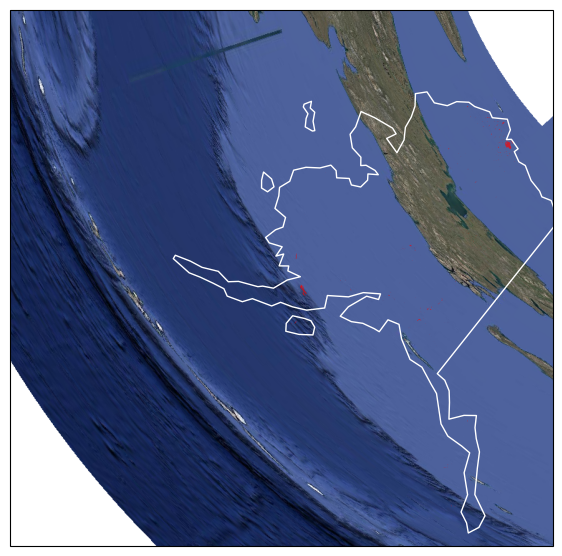

In [16]:
plot_basemap(gdf_combined, CRS.from_authority("ESRI", 102001))

In [65]:
_cartopy_albers(CRS.from_authority("ESRI", 102001))

/Users/ekyzivat/mambaforge/envs/landcover/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


<Projected CRS: +proj=aea +ellps=WGS84 +lon_0=-96 +lat_0=40 +x_0=0 ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Albers Equal Area
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

/Users/ekyzivat/mambaforge/envs/landcover/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


KeyboardInterrupt: 

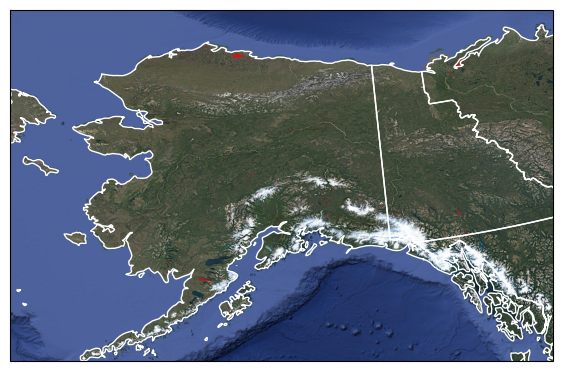

In [19]:
# Set up the plot with a specific Cartopy CRS for Alaska
fig, ax = plt.subplots(
    figsize=(7, 10), 
    subplot_kw={
    # 'projection': 'ESRI:102001'})
    'projection': ccrs.AlbersEqualArea(central_longitude=-152, central_latitude=63)})
    # 'projection': _cartopy_albers(CRS.from_authority("ESRI", 102001))})
        # 'projection': ccrs.AlbersEqualArea(central_longitude=-96, central_latitude=40)})

# Zoom into Alaska
ax.set_extent([-170, -130, 54, 72], crs=ccrs.PlateCarree())

# Add Google Satellite imagery
ax.add_image(img_tiles.GoogleTiles(style='satellite'), 6)

# Add state outlines using Cartopy's features
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='white')

# Plot the GeoDataFrames
a=0.7
gdf_combined.plot(ax=ax, color='red', markersize=5,
                   transform=_crs2ccrs(CRS.from_authority("ESRI", 102001)), alpha=a, label='Efflux lakes')

# ax.legend(title='Legend', loc='upper right')
plt.show()

Write out

In [30]:
gdf_combined.to_file(shp_out)

/var/folders/rv/sn0kln2103b9fs4xl56n3w7w0000gn/T/ipykernel_50317/3348459967.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_combined.to_file(shp_out)
/Users/ekyzivat/mambaforge/envs/landcover/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'LitReviewInfo' to 'LitReviewI'
  ogr_write(
/Users/ekyzivat/mambaforge/envs/landcover/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'index_right' to 'index_righ'
  ogr_write(
/Users/ekyzivat/mambaforge/envs/landcover/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'mean_bound_dist' to 'mean_bound'
  ogr_write(
/Users/ekyzivat/mambaforge/envs/landcover/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'max_bound_dist' to 'max_bound_'
  ogr_write(
/Users/ekyzivat/mambaforge/envs/landcover/lib

# Scratch

In [ ]:
gdf_efflux.crs

<Projected CRS: ESRI:102001>
Name: Canada_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Canada - onshore and offshore - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon.
- bounds: (-141.01, 38.21, -40.73, 86.46)
Coordinate Operation:
- name: Canada_Albers_Equal_Area_Conic
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [ ]:
dir(gdf_efflux.crs)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_crs',
 '_local',
 'area_of_use',
 'axis_info',
 'coordinate_operation',
 'coordinate_system',
 'cs_to_cf',
 'datum',
 'ellipsoid',
 'equals',
 'from_authority',
 'from_cf',
 'from_dict',
 'from_epsg',
 'from_json',
 'from_json_dict',
 'from_proj4',
 'from_string',
 'from_user_input',
 'from_wkt',
 'geodetic_crs',
 'get_geod',
 'get_non_deprecated',
 'is_bound',
 'is_compound',
 'is_deprecated',
 'is_derived',
 'is_engineering',
 'is_exact_same',
 'is_geocentric',
 'is_geographic',
 'is_projected',
 'is_vertical',
 'list_authority',
 'name',
 'prime_meridian',
 'remarks',
 'scope',
 'sou

In [ ]:
gdf_efflux.crs.to_dict()

/Users/ekyzivat/mambaforge/envs/landcover/lib/python3.11/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


{'proj': 'aea',
 'lat_0': 40,
 'lon_0': -96,
 'lat_1': 50,
 'lat_2': 70,
 'x_0': 0,
 'y_0': 0,
 'datum': 'NAD83',
 'units': 'm',
 'no_defs': None,
 'type': 'crs'}

In [ ]:
gdf_efflux.crs.srs

'ESRI:102001'

In [ ]:
gdf_efflux.crs.to_wkt()

'PROJCRS["Canada_Albers_Equal_Area_Conic",BASEGEOGCRS["NAD83",DATUM["North American Datum 1983",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4269]],CONVERSION["Canada_Albers_Equal_Area_Conic",METHOD["Albers Equal Area",ID["EPSG",9822]],PARAMETER["Latitude of false origin",40,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8821]],PARAMETER["Longitude of false origin",-96,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8822]],PARAMETER["Latitude of 1st standard parallel",50,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Latitude of 2nd standard parallel",70,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8824]],PARAMETER["Easting at false origin",0,LENGTHUNIT["metre",1],ID["EPSG",8826]],PARAMETER["Northing at false origin",0,LENGTHUNIT["metre",1],ID["EPSG",8827]]],CS[Cartesian,2],AXIS["(E)",east,ORDER[1],LENGTHUNIT["metre",1]],AXIS["(N)",north,ORDER[2],LENGTHUNIT["metre",1]

In [ ]:
# load.loadEffluxShp().crs.to_dict()['proj']
load.loadEffluxShp().crs.name

'WGS 84'